In [1]:
%matplotlib inline


# Probability Calibration curves

When performing classification one often wants to predict not only the class
label, but also the associated probability. This probability gives some
kind of confidence on the prediction. This example demonstrates how to
visualize how well calibrated the predicted probabilities are using calibration
curves, also known as reliability diagrams. Calibration of an uncalibrated
classifier will also be demonstrated.


In [2]:
# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD 3 clause.

## Dataset

We will use a synthetic binary classification dataset with 100,000 samples
and 20 features. Of the 20 features, only 2 are informative, 10 are
redundant (random combinations of the informative features) and the
remaining 8 are uninformative (random numbers). Of the 100,000 samples, 1,000
will be used for model fitting and the rest for testing.



In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=10, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=42
)

## Calibration curves

### Gaussian Naive Bayes

First, we will compare:

* :class:`~sklearn.linear_model.LogisticRegression` (used as baseline
  since very often, properly regularized logistic regression is well
  calibrated by default thanks to the use of the log-loss)
* Uncalibrated :class:`~sklearn.naive_bayes.GaussianNB`
* :class:`~sklearn.naive_bayes.GaussianNB` with isotonic and sigmoid
  calibration (see `User Guide <calibration>`)

Calibration curves for all 4 conditions are plotted below, with the average
predicted probability for each bin on the x-axis and the fraction of positive
classes in each bin on the y-axis.



In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]

C:\Users\RACHIT\AppData\Local\Temp\ipykernel_20736\1208607498.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")


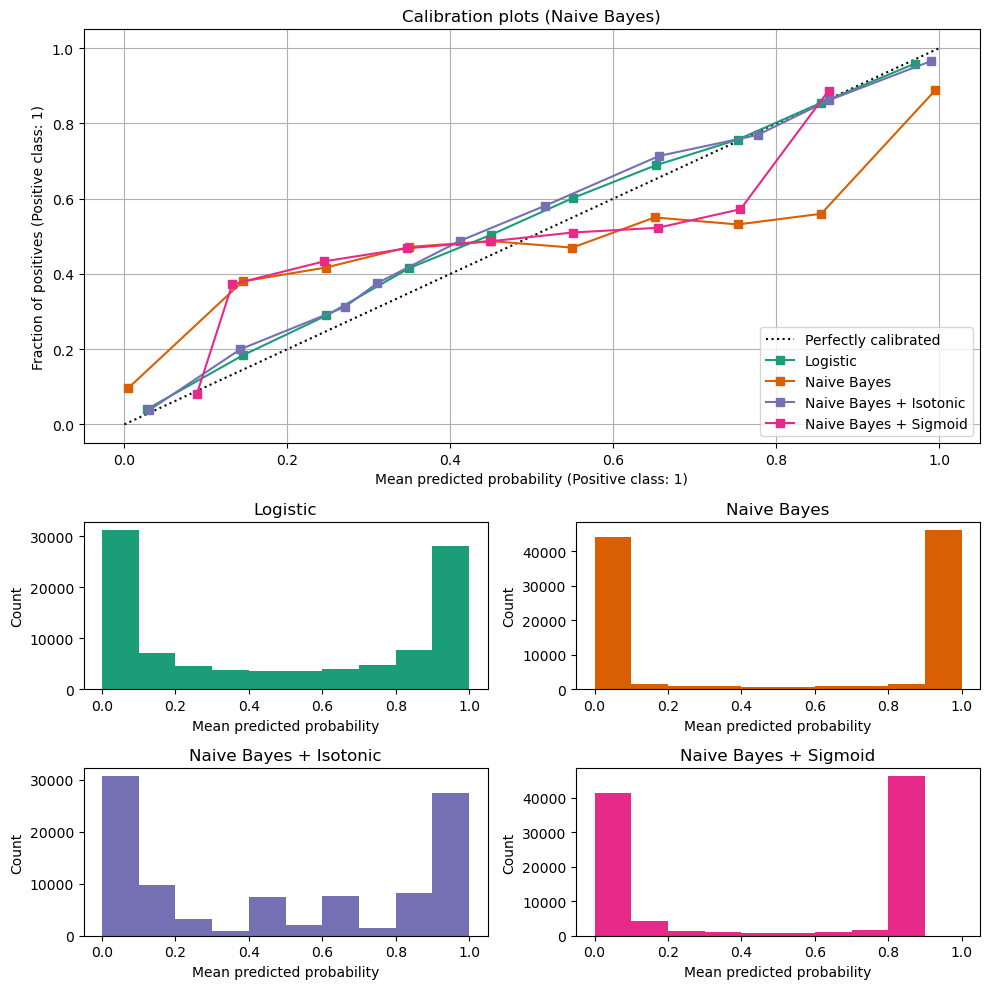

In [5]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

Uncalibrated :class:`~sklearn.naive_bayes.GaussianNB` is poorly calibrated
because of
the redundant features which violate the assumption of feature-independence
and result in an overly confident classifier, which is indicated by the
typical transposed-sigmoid curve. Calibration of the probabilities of
:class:`~sklearn.naive_bayes.GaussianNB` with `isotonic` can fix
this issue as can be seen from the nearly diagonal calibration curve.
`Sigmoid regression <sigmoid_regressor>` also improves calibration
slightly,
albeit not as strongly as the non-parametric isotonic regression. This can be
attributed to the fact that we have plenty of calibration data such that the
greater flexibility of the non-parametric model can be exploited.

Below we will make a quantitative analysis considering several classification
metrics: `brier_score_loss`, `log_loss`,
`precision, recall, F1 score <precision_recall_f_measure_metrics>` and
`ROC AUC <roc_metrics>`.



In [6]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Precision,Recall,F1,Roc auc
Classifier,,,,,,
Logistic,0.098921,0.323178,0.872009,0.851408,0.861586,0.863157
Naive Bayes,0.117608,0.782755,0.857400,0.875941,0.866571,0.865055
Naive Bayes + Isotonic,0.098332,0.370738,0.883065,0.836224,0.859007,0.862690
Naive Bayes + Sigmoid,0.108880,0.368896,0.861106,0.871277,0.866161,0.865300


Notice that although calibration improves the `brier_score_loss` (a
metric composed
of calibration term and refinement term) and `log_loss`, it does not
significantly alter the prediction accuracy measures (precision, recall and
F1 score).
This is because calibration should not significantly change prediction
probabilities at the location of the decision threshold (at x = 0.5 on the
graph). Calibration should however, make the predicted probabilities more
accurate and thus more useful for making allocation decisions under
uncertainty.
Further, ROC AUC, should not change at all because calibration is a
monotonic transformation. Indeed, no rank metrics are affected by
calibration.

### Linear support vector classifier
Next, we will compare:

* :class:`~sklearn.linear_model.LogisticRegression` (baseline)
* Uncalibrated :class:`~sklearn.svm.LinearSVC`. Since SVC does not output
  probabilities by default, we naively scale the output of the
  :term:`decision_function` into [0, 1] by applying min-max scaling.
* :class:`~sklearn.svm.LinearSVC` with isotonic and sigmoid
  calibration (see `User Guide <calibration>`)



In [7]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output for binary classification."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0, 1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [8]:
lr = LogisticRegression(C=1.0)
svc = NaivelyCalibratedLinearSVC(max_iter=10_000)
svc_isotonic = CalibratedClassifierCV(svc, cv=2, method="isotonic")
svc_sigmoid = CalibratedClassifierCV(svc, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (svc, "SVC"),
    (svc_isotonic, "SVC + Isotonic"),
    (svc_sigmoid, "SVC + Sigmoid"),
]

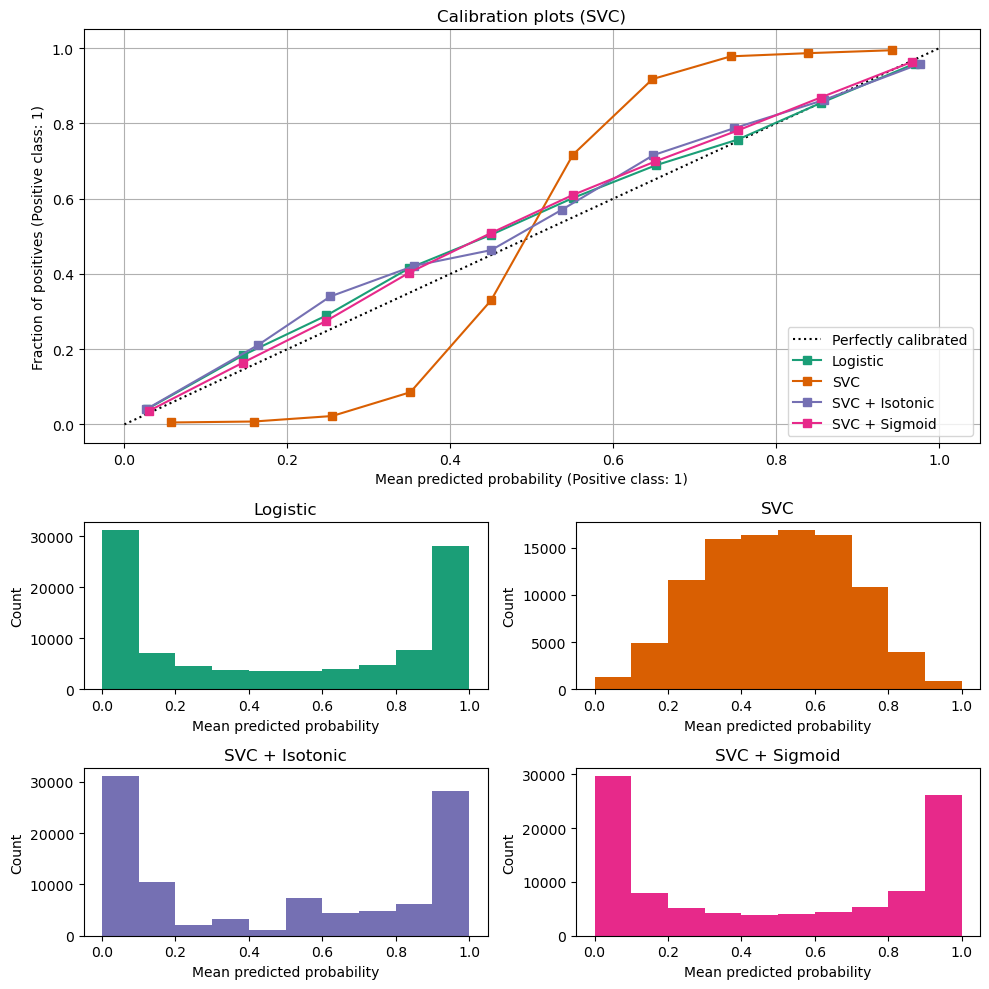

In [9]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (SVC)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

:class:`~sklearn.svm.LinearSVC` shows the opposite
behavior to :class:`~sklearn.naive_bayes.GaussianNB`; the calibration
curve has a sigmoid shape, which is typical for an under-confident
classifier. In the case of :class:`~sklearn.svm.LinearSVC`, this is caused
by the margin property of the hinge loss, which focuses on samples that are
close to the decision boundary (support vectors). Samples that are far
away from the decision boundary do not impact the hinge loss. It thus makes
sense that :class:`~sklearn.svm.LinearSVC` does not try to separate samples
in the high confidence region regions. This leads to flatter calibration
curves near 0 and 1 and is empirically shown with a variety of datasets
in Niculescu-Mizil & Caruana [1]_.

Both kinds of calibration (sigmoid and isotonic) can fix this issue and
yield similar results.

As before, we show the `brier_score_loss`, `log_loss`,
`precision, recall, F1 score <precision_recall_f_measure_metrics>` and
`ROC AUC <roc_metrics>`.



In [10]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Precision,Recall,F1,Roc auc
Classifier,,,,,,
Logistic,0.098921,0.323178,0.872009,0.851408,0.861586,0.863157
SVC,0.144944,0.465663,0.872201,0.851772,0.861865,0.863420
SVC + Isotonic,0.099827,0.377027,0.853032,0.878041,0.865356,0.863306
SVC + Sigmoid,0.098760,0.321306,0.873703,0.848723,0.861032,0.862957


As with :class:`~sklearn.naive_bayes.GaussianNB` above, calibration improves
both `brier_score_loss` and `log_loss` but does not alter the
prediction accuracy measures (precision, recall and F1 score) much.

## Summary

Parametric sigmoid calibration can deal with situations where the calibration
curve of the base classifier is sigmoid (e.g., for
:class:`~sklearn.svm.LinearSVC`) but not where it is transposed-sigmoid
(e.g., :class:`~sklearn.naive_bayes.GaussianNB`). Non-parametric
isotonic calibration can deal with both situations but may require more
data to produce good results.

## References

.. [1] [Predicting Good Probabilities with Supervised Learning](https://dl.acm.org/doi/pdf/10.1145/1102351.1102430),
       A. Niculescu-Mizil & R. Caruana, ICML 2005

